##### With the help of CSV file. we are going to analyse the data collected by the wifi  sniffing tool aurodump-ng.

# Airodump-ng :- 
##### Its a tool Airodump-ng is used for packet capturing of raw 802.11 frames and is particularly suitable for collecting WEP IVs (Initialization Vector) for the intent of using them with aircrack-ng. If you have a GPS receiver connected to the computer, airodump-ng is capable of logging the coordinates of the found access points.

Additionally, airodump-ng writes out several files containing the details of all access points and clients seen.

# Sample how sniffing looks like

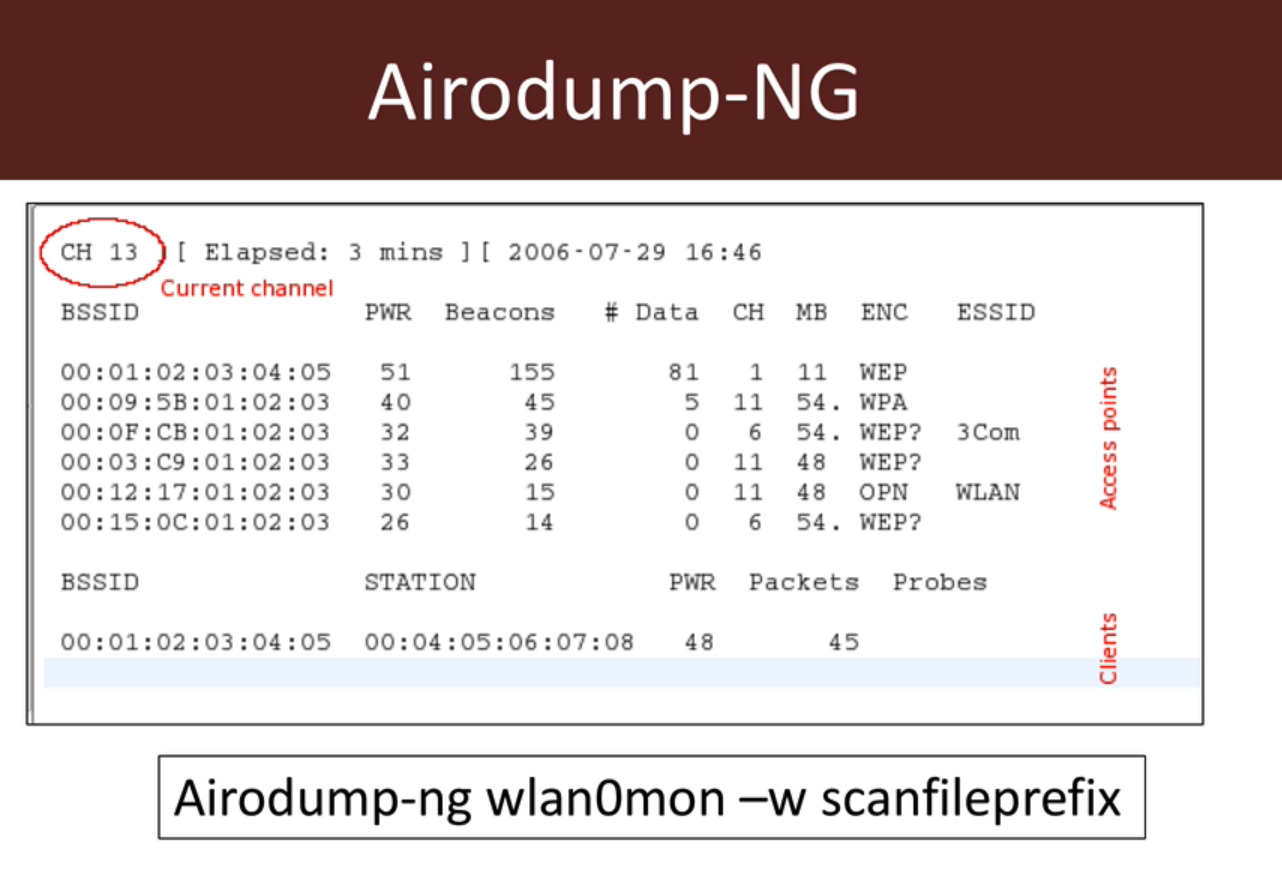

In [1]:
from IPython.display import Image
Image(filename="img1.png",height=500,width=700)

# Airodump-NG Scan CSV Analyzer

We will be using the CSV file created by Airodump-NG to analyze the Wi-Fi network. 
* Access Point analysis
* Client analysis

## 1. Access Point analysis

Using the CSV we will try to answer the following questions:

* Which are the unique SSIDs?
* Are there any hidden SSID networks around?
* How many APs of each SSID?
* Which channels are most occupied?
* How is each SSID's APs spread across the channels?
* Which manufacturers of Wi-Fi cards are most popular?
* Which channels does the AAAAA networks use?
* Which vendor's AP does the AAAAA network use most?
* How is the security posture of the AAAAA network?
* When were each of the APs of AAAAA network discovered?
* Which APs of AAAAA is closest to us? 

## 2. Client analysis

* Unique list of probed SSIDs?
* Most probed SSID?
* Which client has the longest probed SSID list?
* How many clients are connected vs roaming?
* Understanding distribution of clients and APs


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import netaddr
import seaborn as sns
sns.set_color_codes(palette='deep')

In [3]:
aero=open("bu.csv",'r').read()

##### as our csv file contains two csv files inside it i.e client file and AP file so we to seperate our csv file.

In [4]:
client_header = 'Station MAC, First time seen, Last time seen, Power, # packets, BSSID, Probed ESSIDs'

hdi = aero.index(client_header)

In [7]:
from io import StringIO

ap_csv= StringIO(aero[:hdi])

client_csv= StringIO(aero[hdi:])

##### creating csv file

In [8]:
ap_df = pd.read_csv(ap_csv, 
                   sep=',', 
                   skipinitialspace=True,
                    parse_dates = ['First time seen', 'Last time seen']
                   )

In [9]:
client_df = pd.read_csv(client_csv,
                        sep=', ',
                        skipinitialspace=True,
                        engine='python',
                        parse_dates = ['First time seen', 'Last time seen']
                       )

##### using head and tail method

In [10]:
ap_df.head(2)

,BSSID,First time seen,Last time seen,channel,Speed,Privacy,Cipher,Authentication,Power,# beacons,# IV,LAN IP,ID-length,ESSID,Key
0,10:8C:CF:EA:C2:40,2015-02-11 11:41:38,2015-02-11 11:41:42,6,54,WPA2,CCMP,MGT,-47,0,0,0. 0. 0. 0,6,bloomu,NaN
1,00:1C:F9:C1:EF:AA,2015-02-11 11:32:34,2015-02-11 11:41:01,1,54,OPN,NaN,NaN,-35,2,0,0. 0. 0. 0,11,bloomu-open,NaN


In [11]:
client_df.head()

,Station MAC,First time seen,Last time seen,Power,# packets,BSSID,Probed ESSIDs
0,6C:71:D9:D4:15:2B,2015-02-11 11:40:45,2015-02-11 11:42:00,-26,7,10:8C:CF:EA:C0:5B,bloomu-secure
1,40:0E:85:4D:9A:9F,2015-02-11 11:42:00,2015-02-11 11:42:00,-41,4,"(not associated) ,",None
2,00:88:65:1E:56:86,2015-02-11 11:42:00,2015-02-11 11:42:00,-53,3,"(not associated) ,",None
3,0C:BD:51:13:CF:4A,2015-02-11 11:42:00,2015-02-11 11:42:00,-54,1,"(not associated) ,",None
4,F0:DB:E2:64:A6:E6,2015-02-11 11:41:51,2015-02-11 11:41:51,-26,1,"(not associated) ,",None


In [12]:
ap_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 15 columns):
BSSID              250 non-null object
First time seen    250 non-null datetime64[ns]
Last time seen     250 non-null datetime64[ns]
channel            250 non-null int64
Speed              250 non-null int64
Privacy            246 non-null object
Cipher             179 non-null object
Authentication     178 non-null object
Power              250 non-null int64
# beacons          250 non-null int64
# IV               250 non-null int64
LAN IP             250 non-null object
ID-length          250 non-null int64
ESSID              239 non-null object
Key                0 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(6), object(6)
memory usage: 29.4+ KB


In [13]:
client_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684 entries, 0 to 683
Data columns (total 7 columns):
Station MAC        684 non-null object
First time seen    684 non-null datetime64[ns]
Last time seen     684 non-null datetime64[ns]
Power              684 non-null int64
# packets          684 non-null int64
BSSID              684 non-null object
Probed ESSIDs      359 non-null object
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 37.5+ KB


### Lets begin with AP analysis

In [14]:
ap_df.columns

Index(['BSSID', 'First time seen', 'Last time seen', 'channel', 'Speed',
       'Privacy', 'Cipher', 'Authentication', 'Power', '# beacons', '# IV',
       'LAN IP', 'ID-length', 'ESSID', 'Key'],
      dtype='object')

##### changing column name of csv to the simple formatting by removing spaces and lowercasing all the character.

In [15]:
ap_df.rename(columns={ 'BSSID' : 'bssid',
        'First time seen' : 'firstseen',
        'Last time seen' : 'lastseen',
        'channel' : 'channel',
        'Speed' : 'speed',
        'Privacy' : 'privacy',
        'Cipher' : 'cipher',
        'Authentication' : 'authentication',
        'Power' : 'dbpower',
        '# beacons' : 'beacons',
        '# IV' : 'iv',
        'LAN IP' : 'ip',
        'ID-length' : 'idlen',
        'ESSID' : 'essid',
        'Key' : 'key'
    }, inplace=True)

ap_df.head(2)

,bssid,firstseen,lastseen,channel,speed,privacy,cipher,authentication,dbpower,beacons,iv,ip,idlen,essid,key
0,10:8C:CF:EA:C2:40,2015-02-11 11:41:38,2015-02-11 11:41:42,6,54,WPA2,CCMP,MGT,-47,0,0,0. 0. 0. 0,6,bloomu,NaN
1,00:1C:F9:C1:EF:AA,2015-02-11 11:32:34,2015-02-11 11:41:01,1,54,OPN,NaN,NaN,-35,2,0,0. 0. 0. 0,11,bloomu-open,NaN


In [16]:
ap_df.columns

Index(['bssid', 'firstseen', 'lastseen', 'channel', 'speed', 'privacy',
       'cipher', 'authentication', 'dbpower', 'beacons', 'iv', 'ip', 'idlen',
       'essid', 'key'],
      dtype='object')

### Which are the unique SSIDs?

In [17]:
ap_df['essid'].unique()

array(['bloomu', 'bloomu-open', 'bloomu-secure', 'bloomu-psk', 'hpsetup',
       'jlinkwireless', nan, 'saturn', 'SETUP', 'gryffindor',
       'HP-Print-86-ENVY 5530 series', 'mikesuckz', 'airportthru',
       'NETGEAR'], dtype=object)

#### Nan could be any junk value in our any CSV file, But in a case of aerodump-ng we cannot consider it as junk value as it can be any value or any hidden SSID network which are not yet been discovered.

#### so we have to remove or replace these nan value to the hidden ssid no.


### Are there any Hidden SSID networks around?

In [19]:
# Find all ESSIDs which is null i.e. Hidden SSID

ap_df[ap_df.essid.isnull()]

,bssid,firstseen,lastseen,channel,speed,privacy,cipher,authentication,dbpower,beacons,iv,ip,idlen,essid,key
31,10:8C:CF:39:37:A0,2015-02-11 11:35:09,2015-02-11 11:36:09,6,-1,OPN,NaN,NaN,-1,0,2,0. 0. 0. 0,0,NaN,NaN
33,58:BC:27:13:8A:A0,2015-02-11 11:33:02,2015-02-11 11:36:01,6,-1,OPN,NaN,NaN,-1,0,2,0. 0. 0. 0,0,NaN,NaN
42,E8:04:62:0A:32:C0,2015-02-11 11:33:50,2015-02-11 11:35:49,6,-1,OPN,NaN,NaN,-1,0,3,0. 0. 0. 0,0,NaN,NaN
43,10:8C:CF:45:47:00,2015-02-11 11:33:34,2015-02-11 11:33:51,6,-1,OPN,NaN,NaN,-52,0,2,0. 0. 0. 0,0,NaN,NaN
46,DC:7B:94:87:91:30,2015-02-11 11:31:56,2015-02-11 11:31:59,6,-1,NaN,NaN,NaN,-1,0,0,0. 0. 0. 0,0,NaN,NaN
161,E8:04:62:0A:30:FB,2015-02-11 11:32:21,2015-02-11 11:33:04,6,-1,NaN,NaN,NaN,-1,0,0,0. 0. 0. 0,0,NaN,NaN
162,0A:27:22:75:A5:CD,2015-02-11 11:32:20,2015-02-11 11:34:36,6,54,WPA2WPA,CCMP TKIP,PSK,-60,11,0,0. 0. 0. 0,0,NaN,NaN
183,40:F4:EC:DB:22:E0,2015-02-11 11:32:50,2015-02-11 11:36:07,6,-1,NaN,NaN,NaN,-1,0,0,0. 0. 0. 0,0,NaN,NaN
184,E8:04:62:0A:27:80,2015-02-11 11:32:28,2015-02-11 11:36:27,6,-1,OPN,NaN,NaN,-1,0,2,0. 0. 0. 0,0,NaN,NaN
196,40:F4:EC:DA:F9:C0,2015-02-11 11:36:52,2015-02-11 11:37:06,6,-1,NaN,NaN,NaN,-1,0,0,0. 0. 0. 0,0,NaN,NaN


In [20]:
ap_df.essid.hasnans

True

In [21]:
# Let's replace the NaNs with "Hidden SSID" 

ap_df.essid.fillna('Hidden SSID', inplace=True)

ap_df.essid.hasnans

False

In [22]:
ap_df[ap_df.essid == 'Hidden SSID'].head(3)

,bssid,firstseen,lastseen,channel,speed,privacy,cipher,authentication,dbpower,beacons,iv,ip,idlen,essid,key
31,10:8C:CF:39:37:A0,2015-02-11 11:35:09,2015-02-11 11:36:09,6,-1,OPN,NaN,NaN,-1,0,2,0. 0. 0. 0,0,Hidden SSID,NaN
33,58:BC:27:13:8A:A0,2015-02-11 11:33:02,2015-02-11 11:36:01,6,-1,OPN,NaN,NaN,-1,0,2,0. 0. 0. 0,0,Hidden SSID,NaN
42,E8:04:62:0A:32:C0,2015-02-11 11:33:50,2015-02-11 11:35:49,6,-1,OPN,NaN,NaN,-1,0,3,0. 0. 0. 0,0,Hidden SSID,NaN


### How many APs of each SSID?

In [23]:
# Let us now get the ESSID counts

essid_stats = ap_df.essid.value_counts()

essid_stats

bloomu                          62
bloomu-secure                   58
bloomu-open                     57
bloomu-psk                      53
Hidden SSID                     11
NETGEAR                          1
HP-Print-86-ENVY 5530 series     1
hpsetup                          1
saturn                           1
airportthru                      1
gryffindor                       1
jlinkwireless                    1
mikesuckz                        1
SETUP                            1
Name: essid, dtype: int64

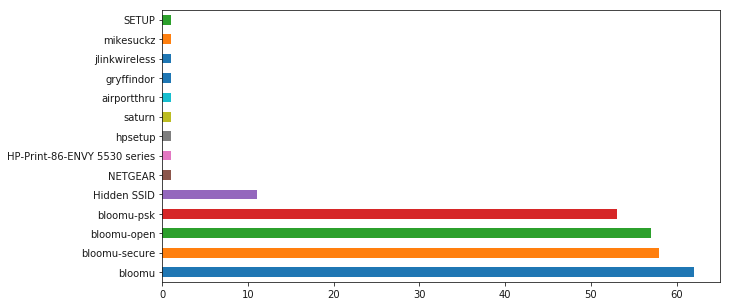

In [24]:
# Let's plot this with a Bar Chart

essid_stats.plot(kind='barh', figsize=(10,5))

### Which channels are most occupied?

In [26]:
ap_df.channel.value_counts()

6     105
11     94
1      49
10      1
4       1
Name: channel, dtype: int64

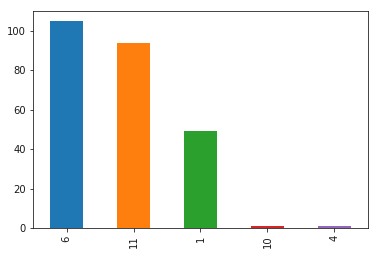

In [27]:
ap_df.channel.value_counts().plot(kind='bar')

### How is each SSID's APs spread across the channels?

In [28]:
ap_df.groupby(['essid', 'channel'])['channel'].count()

essid                         channel
HP-Print-86-ENVY 5530 series  6           1
Hidden SSID                   6          11
NETGEAR                       11          1
SETUP                         11          1
airportthru                   10          1
bloomu                        1          13
                              6          25
                              11         24
bloomu-open                   1          13
                              6          21
                              11         23
bloomu-psk                    1          10
                              6          21
                              11         22
bloomu-secure                 1          13
                              6          22
                              11         23
gryffindor                    6           1
hpsetup                       6           1
jlinkwireless                 6           1
mikesuckz                     6           1
saturn                        4       

In [29]:
ap_df.groupby(['essid', 'channel'])['channel'].count().unstack()

channel,1,4,6,10,11
essid,,,,,
HP-Print-86-ENVY 5530 series,NaN,NaN,1.0,NaN,NaN
Hidden SSID,NaN,NaN,11.0,NaN,NaN
NETGEAR,NaN,NaN,NaN,NaN,1.0
SETUP,NaN,NaN,NaN,NaN,1.0
airportthru,NaN,NaN,NaN,1.0,NaN
bloomu,13.0,NaN,25.0,NaN,24.0
bloomu-open,13.0,NaN,21.0,NaN,23.0
bloomu-psk,10.0,NaN,21.0,NaN,22.0
bloomu-secure,13.0,NaN,22.0,NaN,23.0


In [30]:
ap_df.groupby(['essid', 'channel'])['channel'].count().unstack().fillna(0)

channel,1,4,6,10,11
essid,,,,,
HP-Print-86-ENVY 5530 series,0.0,0.0,1.0,0.0,0.0
Hidden SSID,0.0,0.0,11.0,0.0,0.0
NETGEAR,0.0,0.0,0.0,0.0,1.0
SETUP,0.0,0.0,0.0,0.0,1.0
airportthru,0.0,0.0,0.0,1.0,0.0
bloomu,13.0,0.0,25.0,0.0,24.0
bloomu-open,13.0,0.0,21.0,0.0,23.0
bloomu-psk,10.0,0.0,21.0,0.0,22.0
bloomu-secure,13.0,0.0,22.0,0.0,23.0


In [31]:
channel_data = ap_df.groupby(['essid', 'channel'])['channel'].count().unstack().fillna(0)

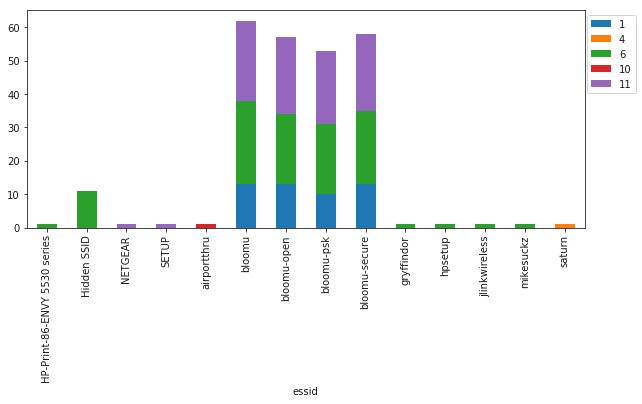

In [32]:
channel_data.plot(kind='bar', stacked=True, figsize=(10,4)).legend(bbox_to_anchor=(1.1, 1))

### Which manufacturers of Wi-Fi cards are most popular?

In [33]:
# AP vendors can be figured out by the first 3 bytes of the MAC address. 
# We don't have the OUI list  for the conversion but we can find the most 
# common first 3 bytes of the MAC address


manufacturer = ap_df.bssid.str.extract('(..:..:..)', expand=False)

manufacturer.head(10)

0    10:8C:CF
1    00:1C:F9
2    00:1C:F9
3    00:23:AB
4    00:1C:F9
5    00:23:AB
6    10:8C:CF
7    00:23:AB
8    00:23:AB
9    00:23:AB
Name: bssid, dtype: object

In [34]:
manufacturer.value_counts()

10:8C:CF    94
E8:04:62    35
A0:CF:5B    23
58:BC:27    16
40:F4:EC    14
00:1C:0E     8
00:1C:F9     8
00:23:AB     8
6C:FA:89     8
B0:00:B4     6
DC:7B:94     5
44:E4:D9     4
88:75:56     4
54:4A:00     4
00:25:9C     1
FC:15:B4     1
18:EF:63     1
2E:25:B3     1
06:27:22     1
0A:27:22     1
1A:45:CB     1
00:25:00     1
00:26:F2     1
26:43:AB     1
00:1E:E5     1
20:AA:4B     1
00:24:14     1
Name: bssid, dtype: int64

In [35]:
netaddr.OUI('10:8C:CF'.replace(':', '-')).registration().org

'Cisco Systems, Inc'

In [37]:
for x in manufacturer.value_counts().index[:10]: 
    print (x)

10:8C:CF
E8:04:62
A0:CF:5B
58:BC:27
40:F4:EC
00:1C:0E
00:1C:F9
00:23:AB
6C:FA:89
B0:00:B4


In [38]:
def manufac(oui) :
    try:
        return netaddr.OUI(oui.replace(':', '-')).registration().org
    except:
        return "Unknown"

[ manufac(oui) for oui in manufacturer.value_counts().index]

['Cisco Systems, Inc',
 'Cisco Systems, Inc',
 'Cisco Systems, Inc',
 'Cisco Systems, Inc',
 'Cisco Systems, Inc',
 'Cisco Systems, Inc',
 'Cisco Systems, Inc',
 'Cisco Systems, Inc',
 'Cisco Systems, Inc',
 'Cisco Systems, Inc',
 'Cisco Systems, Inc',
 'Cisco Systems, Inc',
 'Cisco Systems, Inc',
 'Cisco Systems, Inc',
 'Cisco-Linksys, LLC',
 'Hewlett Packard',
 'Cisco Systems, Inc',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Apple, Inc.',
 'NETGEAR',
 'Unknown',
 'Cisco-Linksys, LLC',
 'Cisco-Linksys, LLC',
 'Cisco Systems, Inc']

### Which channels does the bloomuXXX networks use?

In [39]:
ap_channel = ap_df[ap_df.essid.str.startswith('bloomu')][['essid', 'channel']]

In [40]:
ap_channel.head(5)

,essid,channel
0,bloomu,6
1,bloomu-open,1
2,bloomu-secure,1
3,bloomu-secure,1
4,bloomu-psk,1


In [41]:
ap_channel_dist = ap_channel.groupby(['essid', 'channel'])['channel'].count()

ap_channel_dist

essid          channel
bloomu         1          13
               6          25
               11         24
bloomu-open    1          13
               6          21
               11         23
bloomu-psk     1          10
               6          21
               11         22
bloomu-secure  1          13
               6          22
               11         23
Name: channel, dtype: int64

In [42]:
ap_channel_dist.unstack()

channel,1,6,11
essid,,,
bloomu,13,25,24
bloomu-open,13,21,23
bloomu-psk,10,21,22
bloomu-secure,13,22,23


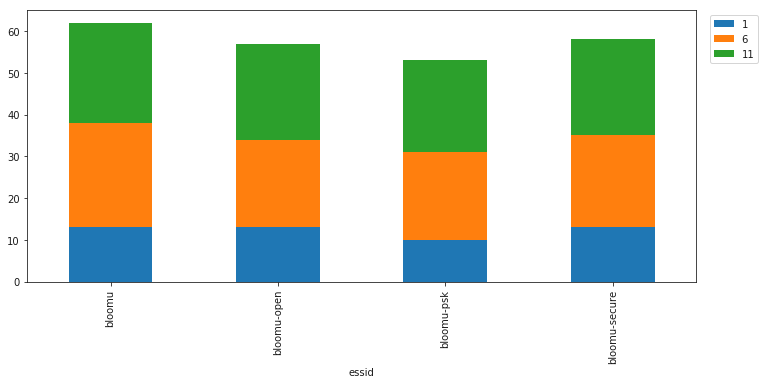

In [43]:
ap_channel_dist.unstack().plot(kind='bar', stacked=True, figsize=(12,5)).legend(bbox_to_anchor=(1.1, 1))

In [44]:
ap_channel_dist.unstack().T

essid,bloomu,bloomu-open,bloomu-psk,bloomu-secure
channel,,,,
1,13,13,10,13
6,25,21,21,22
11,24,23,22,23


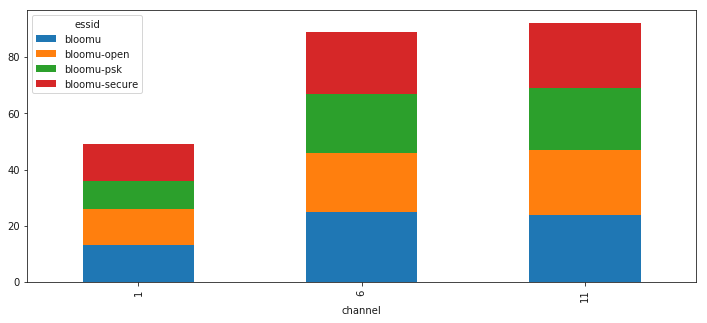

In [45]:
ap_channel_dist.unstack().T.plot(kind='bar', stacked=True, figsize=(12,5))

### Which vendor's AP does the bloomuXXX network use most?

In [46]:
all_bssids = ap_df[ap_df.essid.str.startswith('bloomu')].bssid

all_bssids.head(5)

0    10:8C:CF:EA:C2:40
1    00:1C:F9:C1:EF:AA
2    00:1C:F9:C1:EF:AB
3    00:23:AB:27:CB:1B
4    00:1C:F9:C1:EF:A2
Name: bssid, dtype: object

In [48]:
all_vendors = all_bssids.str.extract('(..:..:..)', expand=False)

all_vendors.head(5)

0    10:8C:CF
1    00:1C:F9
2    00:1C:F9
3    00:23:AB
4    00:1C:F9
Name: bssid, dtype: object

In [49]:
all_vendors.value_counts()

10:8C:CF    92
E8:04:62    32
A0:CF:5B    23
58:BC:27    15
40:F4:EC    12
6C:FA:89     8
00:1C:0E     8
00:23:AB     8
00:1C:F9     8
B0:00:B4     6
54:4A:00     4
DC:7B:94     4
44:E4:D9     4
88:75:56     4
00:24:14     1
18:EF:63     1
Name: bssid, dtype: int64

In [50]:
all_vendors.value_counts().reset_index()

,index,bssid
0,10:8C:CF,92
1,E8:04:62,32
2,A0:CF:5B,23
3,58:BC:27,15
4,40:F4:EC,12
5,6C:FA:89,8
6,00:1C:0E,8
7,00:23:AB,8
8,00:1C:F9,8
9,B0:00:B4,6


In [51]:
tempdf = all_vendors.value_counts().reset_index()

tempdf["manufacturer"] = tempdf['index'].apply(lambda x: manufac(x))

tempdf

,index,bssid,manufacturer
0,10:8C:CF,92,"Cisco Systems, Inc"
1,E8:04:62,32,"Cisco Systems, Inc"
2,A0:CF:5B,23,"Cisco Systems, Inc"
3,58:BC:27,15,"Cisco Systems, Inc"
4,40:F4:EC,12,"Cisco Systems, Inc"
5,6C:FA:89,8,"Cisco Systems, Inc"
6,00:1C:0E,8,"Cisco Systems, Inc"
7,00:23:AB,8,"Cisco Systems, Inc"
8,00:1C:F9,8,"Cisco Systems, Inc"
9,B0:00:B4,6,"Cisco Systems, Inc"


In [52]:
tempdf.manufacturer.value_counts()

Cisco Systems, Inc    16
Name: manufacturer, dtype: int64

### How is the security posture of the bloomuXXX network?

In [55]:
bloomu_df = ap_df[ap_df.essid.str.startswith('bloomu')]

print ('Any NaNs? ' , bloomu_df.privacy.hasnans)

print ('Unique Set? ', bloomu_df.privacy.unique())

get_details = bloomu_df.groupby(['essid', 'privacy'])['privacy'].count()

temp_df = get_details.unstack('privacy').fillna(0)

Any NaNs?  False
Unique Set?  ['WPA2' 'OPN ' 'WPA2OPN ']


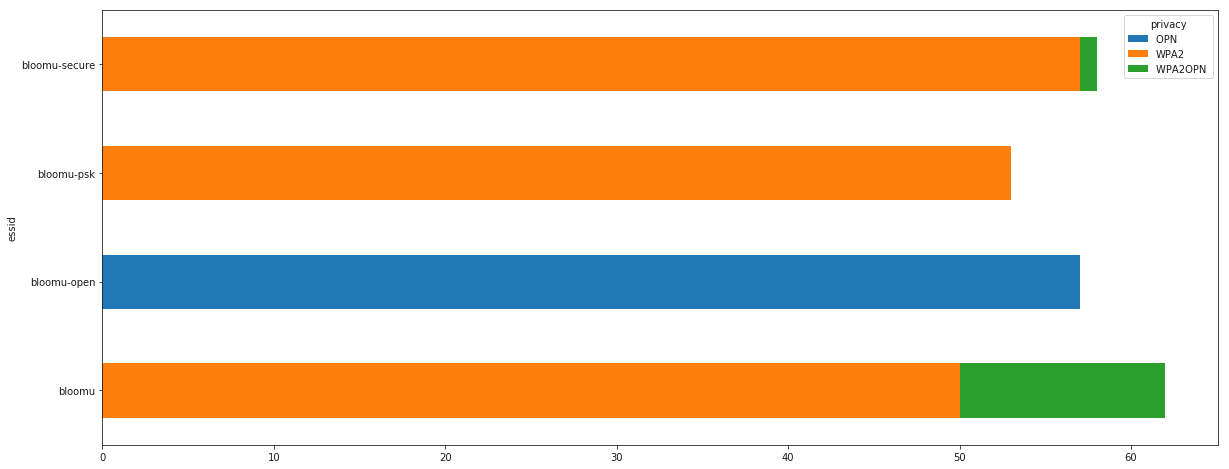

In [56]:
temp_df.plot(kind='barh', stacked=True, figsize=(20,8))

### Which APs of bloomuXXX is closest to us? 

In [57]:
# Check for anomalies in the power values

bloomu_df[bloomu_df.dbpower == -1]

,bssid,firstseen,lastseen,channel,speed,privacy,cipher,authentication,dbpower,beacons,iv,ip,idlen,essid,key


In [58]:
bloomu_df.sort_values(['dbpower'], ascending=False).head(3)

,bssid,firstseen,lastseen,channel,speed,privacy,cipher,authentication,dbpower,beacons,iv,ip,idlen,essid,key
108,10:8C:CF:B4:B2:EA,2015-02-11 11:22:23,2015-02-11 11:24:06,1,54,OPN,NaN,NaN,-22,0,0,0. 0. 0. 0,11,bloomu-open,NaN
248,B0:00:B4:21:B2:50,2015-02-11 11:36:13,2015-02-11 11:42:49,6,54,WPA2,CCMP,MGT,-27,511,1577,0. 0. 0. 0,6,bloomu,NaN
180,10:8C:CF:38:5D:5A,2015-02-11 11:33:08,2015-02-11 11:35:47,11,54,OPN,NaN,NaN,-28,2,0,0. 0. 0. 0,11,bloomu-open,NaN


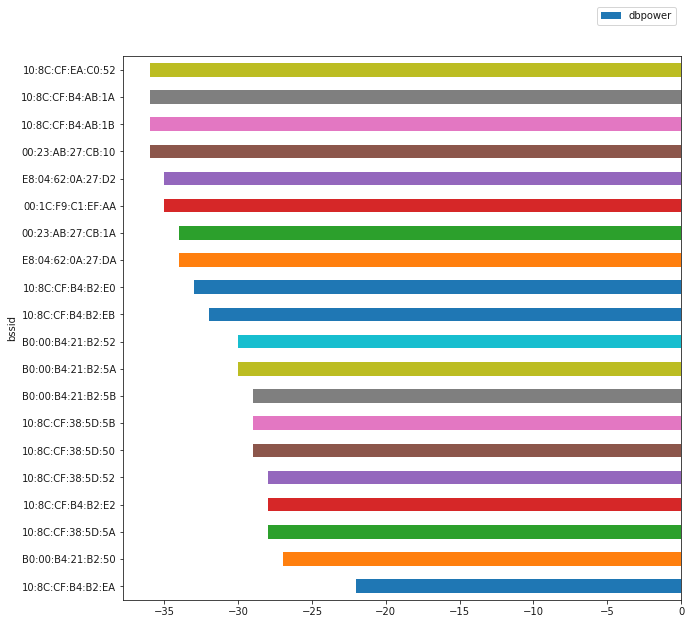

In [59]:
bloomu_df.sort_values(['dbpower'], ascending=False).head(20).reset_index(drop=True).plot(
    x='bssid', 
    y='dbpower', 
    kind='barh',
    figsize=(10,10),
).legend(bbox_to_anchor=(1, 1.1))

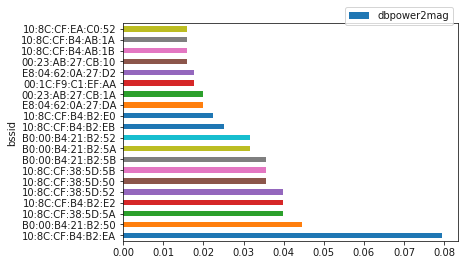

In [60]:
# The scale in the above figure is not representative of the power level difference as it
# wrongly assumes that the scale is linear

dbm = bloomu_df.sort_values(
    ['dbpower'], 
    ascending=False).head(20).reset_index(drop=True)[['bssid', 'dbpower']]

def db2val(dbval):
    return 10.**(dbval/20.)
    

dbm['dbpower2mag'] = dbm.dbpower.apply(db2val)

dbm.plot(
    x='bssid', 
    y='dbpower2mag', 
    kind='barh',
).legend(bbox_to_anchor=(1, 1.1))

### Plotting bloomuXXX APs as they were discovered

In [61]:
bloomu_df.dtypes

bssid                     object
firstseen         datetime64[ns]
lastseen          datetime64[ns]
channel                    int64
speed                      int64
privacy                   object
cipher                    object
authentication            object
dbpower                    int64
beacons                    int64
iv                         int64
ip                        object
idlen                      int64
essid                     object
key                      float64
dtype: object

In [62]:
discovered = bloomu_df[['bssid', 'firstseen']].sort_values('firstseen').reset_index(drop=True)

discovered.head(15)

,bssid,firstseen
0,A0:CF:5B:6B:2E:8B,2015-02-11 11:20:07
1,00:1C:0E:26:AE:E0,2015-02-11 11:20:07
2,A0:CF:5B:9F:C8:3B,2015-02-11 11:20:07
3,54:4A:00:79:95:70,2015-02-11 11:20:07
4,10:8C:CF:EA:24:40,2015-02-11 11:20:07
5,A0:CF:5B:9F:C8:3A,2015-02-11 11:20:07
6,A0:CF:5B:9F:32:3B,2015-02-11 11:20:07
7,A0:CF:5B:6B:2E:8A,2015-02-11 11:20:07
8,00:1C:0E:26:AE:EA,2015-02-11 11:20:07
9,54:4A:00:79:95:72,2015-02-11 11:20:07


In [63]:
discovered['timeoffset'] = (discovered.firstseen - discovered.firstseen.loc[0])/np.timedelta64(1, 's')

In [64]:
discovered.head(15)

,bssid,firstseen,timeoffset
0,A0:CF:5B:6B:2E:8B,2015-02-11 11:20:07,0.0
1,00:1C:0E:26:AE:E0,2015-02-11 11:20:07,0.0
2,A0:CF:5B:9F:C8:3B,2015-02-11 11:20:07,0.0
3,54:4A:00:79:95:70,2015-02-11 11:20:07,0.0
4,10:8C:CF:EA:24:40,2015-02-11 11:20:07,0.0
5,A0:CF:5B:9F:C8:3A,2015-02-11 11:20:07,0.0
6,A0:CF:5B:9F:32:3B,2015-02-11 11:20:07,0.0
7,A0:CF:5B:6B:2E:8A,2015-02-11 11:20:07,0.0
8,00:1C:0E:26:AE:EA,2015-02-11 11:20:07,0.0
9,54:4A:00:79:95:72,2015-02-11 11:20:07,0.0


In [65]:
discovered.tail(15)

,bssid,firstseen,timeoffset
215,10:8C:CF:EA:C0:5B,2015-02-11 11:40:45,1238.0
216,10:8C:CF:EA:C0:50,2015-02-11 11:40:52,1245.0
217,10:8C:CF:EA:C0:52,2015-02-11 11:40:53,1246.0
218,10:8C:CF:B4:AC:6B,2015-02-11 11:41:01,1254.0
219,10:8C:CF:B4:AC:6A,2015-02-11 11:41:01,1254.0
220,10:8C:CF:B4:AC:60,2015-02-11 11:41:01,1254.0
221,40:F4:EC:DA:F7:7A,2015-02-11 11:41:06,1259.0
222,40:F4:EC:DA:F7:7B,2015-02-11 11:41:06,1259.0
223,40:F4:EC:DA:F7:70,2015-02-11 11:41:06,1259.0
224,40:F4:EC:DA:F7:72,2015-02-11 11:41:06,1259.0


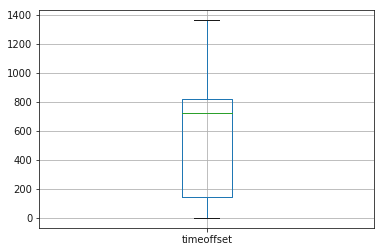

In [66]:
discovered.boxplot(column=['timeoffset'], return_type='axes')

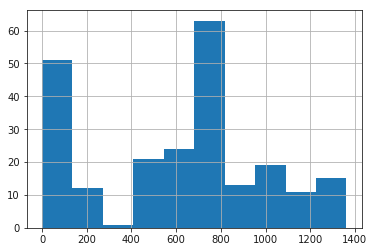

In [67]:
discovered.timeoffset.hist()

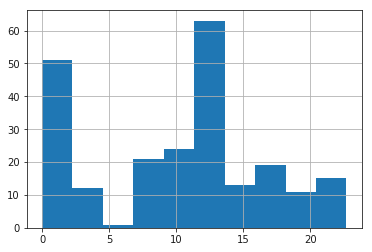

In [68]:
# Let's look at this in minutes 

(discovered.timeoffset/60).hist()

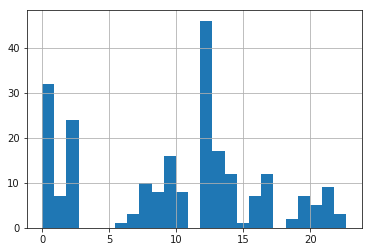

In [69]:
(discovered.timeoffset/60).hist(bins=25)

## Client Analysis

In [70]:
client_df.head(1)

,Station MAC,First time seen,Last time seen,Power,# packets,BSSID,Probed ESSIDs
0,6C:71:D9:D4:15:2B,2015-02-11 11:40:45,2015-02-11 11:42:00,-26,7,10:8C:CF:EA:C0:5B,bloomu-secure


In [71]:
client_df.columns = ['clientmac', 'firstseen', 'lastseen', 'power', 'numpkts', 'bssid', 'probedssids']

client_df.head(1)

,clientmac,firstseen,lastseen,power,numpkts,bssid,probedssids
0,6C:71:D9:D4:15:2B,2015-02-11 11:40:45,2015-02-11 11:42:00,-26,7,10:8C:CF:EA:C0:5B,bloomu-secure


In [72]:
client_df.bssid.head(10)

0     10:8C:CF:EA:C0:5B
1    (not associated) ,
2    (not associated) ,
3    (not associated) ,
4    (not associated) ,
5     10:8C:CF:EA:C0:5B
6     (not associated) 
7     B0:00:B4:21:B2:50
8    00:23:AB:BC:D8:C0,
9    (not associated) ,
Name: bssid, dtype: object

In [73]:
client_df['bssid'] = client_df.bssid.str.replace(',', '')

client_df.bssid.head(10)

0    10:8C:CF:EA:C0:5B
1    (not associated) 
2    (not associated) 
3    (not associated) 
4    (not associated) 
5    10:8C:CF:EA:C0:5B
6    (not associated) 
7    B0:00:B4:21:B2:50
8    00:23:AB:BC:D8:C0
9    (not associated) 
Name: bssid, dtype: object

In [74]:
all_probed_ssids_list = []

def createprobedlist(x) :
    if x:
        all_probed_ssids_list.extend(x.strip().split(','))
        
client_df.probedssids.apply(createprobedlist)

all_probed_ssids_list

['bloomu-secure',
 'bloomu-secure',
 'bloomu',
 'bloomu',
 'bloomu',
 'bloomu',
 'bloomu',
 'bloomu-open',
 'bloomu-secure',
 'bloomu',
 'bloomu-open',
 'bloomu',
 'bloomu',
 'bloomu',
 'bloomu',
 'bloomu',
 'bloomu',
 'bloomu-secure',
 'Anthonys',
 'acf1dffe7619',
 'HOME-C438',
 'MOTOROLA-4D711',
 'Geisinger Guest',
 'xfinitywifi',
 'CableWiFi',
 'WG505',
 'DDGuestWifi',
 'bloomu-guest',
 'bloomu',
 'bloomu-secure',
 'bloomu',
 'bloomu',
 'bloomu',
 'dymondguest',
 'bloomu',
 'bloomu-secure',
 'bloomu',
 'bloomu-secure',
 'bloomu',
 'bloomu-secure',
 'bloomu',
 'bloomu',
 'bloomu',
 'bloomu',
 'bloomu',
 'bloomu',
 'bloomu-secure',
 'bloomu',
 'bloomu',
 'ARRIS-CE42',
 'NETGEAR14',
 'You Got Yirced',
 'HOME-A242',
 'EHRHARDTS_PUBLIC',
 'hoots',
 'POW61',
 'bloomu-secure',
 'bloomu',
 'mcdonalds',
 'mcDonalds',
 'bloomu-secure',
 'bloomu',
 'bloomu',
 'bloomu',
 'bloomu',
 'bloomu-secure',
 'bloomu',
 'bloomu-open',
 'bloomu-secure',
 'bloomu',
 'bloomu',
 'bloomu',
 'bloomu',
 'bloomu

In [75]:
set(all_probed_ssids_list)

{'04B412739941',
 '122 Irondale Road',
 '570girls',
 'ARRIS-57E2',
 'ARRIS-CE42',
 'Anthonys',
 'Atlantis',
 'BIDA--Office-guest',
 'BU985',
 'Bill Wi the Science Fi',
 'BlueDog',
 'Break Time',
 'CableWiFi',
 'CanonPrinter',
 'Cisco06934',
 'Conallen',
 'Courtyard_Guest',
 'DDGuestWifi',
 'DE9V1',
 'DIRECT-',
 'DRMC-GuestAccess',
 'Do Not Use 2',
 'Dunkin Donuts St Clair',
 'EHRHARDTS_PUBLIC',
 'Edc9sse1',
 'Elite2',
 'Faith_Guest',
 'FineString HD',
 'FlyPittsburgh',
 'Fog & Flame Public 2.4GHz',
 'GALAXY_S4_2178',
 'GFC_01',
 'Geisinger Guest',
 'Guest SMASD',
 'HOME-57C2',
 'HOME-A178',
 'HOME-A242',
 'HOME-AF56-2.4',
 'HOME-C438',
 'HOME-FD3E',
 'HOSS3048',
 'HP-Print-39-ENVY 4500 series',
 'Honse',
 'ITG@Avalon31',
 'Jjenrette',
 'Kings',
 'LTET2',
 'Lab Wireless',
 'MOTOROLA-4D711',
 'MSA-FALH',
 "MT's hotspot",
 'Macysfreewifi',
 'Mothership',
 'NETGEAR-2.4-G',
 'NETGEAR14',
 'NETGEAR19',
 'OceanNet Public Internet FC',
 'POW61',
 'RNNCOP-PC-Wireless',
 "Richard Irvin's Guest N

### Which is the most probed SSID across all clients?

In [77]:
templist = []

def ProbedssidClientmac(row) :
    if row.probedssids:
        for pssid in row.probedssids.strip().split(',') :
            templist.append([row.clientmac, pssid])

client_df.apply(ProbedssidClientmac, axis=1)

templist

[['6C:71:D9:D4:15:2B', 'bloomu-secure'],
 ['04:F1:3E:8B:C0:AF', 'bloomu-secure'],
 ['A8:5B:78:3F:CD:0F', 'bloomu'],
 ['70:3E:AC:9A:E0:0A', 'bloomu'],
 ['2C:54:CF:F4:9F:04', 'bloomu'],
 ['CC:3A:61:D9:ED:C2', 'bloomu'],
 ['F0:DB:E2:62:91:B0', 'bloomu'],
 ['60:BE:B5:E6:0B:86', 'bloomu-open'],
 ['3C:25:D7:C1:1F:68', 'bloomu-secure'],
 ['24:A2:E1:C2:62:E7', 'bloomu'],
 ['90:72:40:94:EA:A7', 'bloomu-open'],
 ['B0:34:95:93:49:5C', 'bloomu'],
 ['78:FD:94:09:EE:19', 'bloomu'],
 ['D8:BB:2C:14:2D:ED', 'bloomu'],
 ['90:FD:61:AF:E0:5E', 'bloomu'],
 ['D8:BB:2C:E8:93:CC', 'bloomu'],
 ['40:0E:85:05:A2:D7', 'bloomu'],
 ['68:17:29:41:4A:0B', 'bloomu-secure'],
 ['F8:F1:B6:3C:98:98', 'Anthonys'],
 ['F8:F1:B6:3C:98:98', 'acf1dffe7619'],
 ['F8:F1:B6:3C:98:98', 'HOME-C438'],
 ['F8:F1:B6:3C:98:98', 'MOTOROLA-4D711'],
 ['F8:F1:B6:3C:98:98', 'Geisinger Guest'],
 ['F8:F1:B6:3C:98:98', 'xfinitywifi'],
 ['F8:F1:B6:3C:98:98', 'CableWiFi'],
 ['F8:F1:B6:3C:98:98', 'WG505'],
 ['F8:F1:B6:3C:98:98', 'DDGuestWifi'],
 ['F

In [78]:
newdf = pd.DataFrame(templist)

newdf.head(3)

,0,1
0,6C:71:D9:D4:15:2B,bloomu-secure
1,04:F1:3E:8B:C0:AF,bloomu-secure
2,A8:5B:78:3F:CD:0F,bloomu


In [79]:
newdf.columns = ['clientmac', 'pssid']

newdf.head(1)

,clientmac,pssid
0,6C:71:D9:D4:15:2B,bloomu-secure


In [80]:
newdf.pssid.value_counts().head(10)

bloomu           197
bloomu-secure    127
bloomu-open        9
bloomu-guest       3
belkin54g          2
DE9V1              1
hoots              1
tf2607             1
FlyPittsburgh      1
lcccwlan           1
Name: pssid, dtype: int64

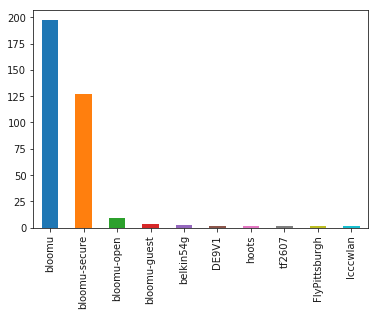

In [81]:
newdf.pssid.value_counts().head(10).plot(kind='bar')

### Which client has the longest list of Probed SSIDs?

In [82]:
newdf.clientmac.value_counts().head(8)

14:10:9F:51:CE:2E    10
44:D8:84:BA:77:1E    10
F8:F1:B6:3C:98:98    10
D8:D1:CB:3B:B6:CA    10
08:70:45:78:A8:7C    10
18:E7:F4:9E:14:01     7
88:C6:63:21:33:EF     6
34:BB:26:9D:39:D7     5
Name: clientmac, dtype: int64

In [83]:
newdf[newdf['clientmac'] == 'D8:D1:CB:3B:B6:CA']

,clientmac,pssid
384,D8:D1:CB:3B:B6:CA,04B412739941
385,D8:D1:CB:3B:B6:CA,BIDA--Office-guest
386,D8:D1:CB:3B:B6:CA,lcccwlan
387,D8:D1:CB:3B:B6:CA,TWDG991T
388,D8:D1:CB:3B:B6:CA,SweetFrog Guest
389,D8:D1:CB:3B:B6:CA,Faith_Guest
390,D8:D1:CB:3B:B6:CA,GFC_01
391,D8:D1:CB:3B:B6:CA,corky
392,D8:D1:CB:3B:B6:CA,Macysfreewifi
393,D8:D1:CB:3B:B6:CA,Richard Irvin's Guest Network


In [84]:
netaddr.OUI('D8:D1:CB'.replace(':', '-')).registration().org

'Apple, Inc.'

### Number of Clients connect to an AP vs roaming?

In [85]:
client_df.count()

clientmac      684
firstseen      684
lastseen       684
power          684
numpkts        684
bssid          684
probedssids    359
dtype: int64

In [86]:
client_df.bssid.str.contains('not associated').value_counts()

True     480
False    204
Name: bssid, dtype: int64

In [87]:
client_df.head(10)

,clientmac,firstseen,lastseen,power,numpkts,bssid,probedssids
0,6C:71:D9:D4:15:2B,2015-02-11 11:40:45,2015-02-11 11:42:00,-26,7,10:8C:CF:EA:C0:5B,bloomu-secure
1,40:0E:85:4D:9A:9F,2015-02-11 11:42:00,2015-02-11 11:42:00,-41,4,(not associated),None
2,00:88:65:1E:56:86,2015-02-11 11:42:00,2015-02-11 11:42:00,-53,3,(not associated),None
3,0C:BD:51:13:CF:4A,2015-02-11 11:42:00,2015-02-11 11:42:00,-54,1,(not associated),None
4,F0:DB:E2:64:A6:E6,2015-02-11 11:41:51,2015-02-11 11:41:51,-26,1,(not associated),None
5,04:F1:3E:8B:C0:AF,2015-02-11 11:41:52,2015-02-11 11:41:52,-40,5,10:8C:CF:EA:C0:5B,bloomu-secure
6,A8:5B:78:3F:CD:0F,2015-02-11 11:41:51,2015-02-11 11:41:51,-56,1,(not associated),bloomu
7,70:3E:AC:9A:E0:0A,2015-02-11 11:39:28,2015-02-11 11:41:41,-57,27,B0:00:B4:21:B2:50,bloomu
8,50:55:27:DA:F6:36,2015-02-11 11:36:15,2015-02-11 11:41:28,-35,30,00:23:AB:BC:D8:C0,None
9,34:4D:F7:92:C2:BB,2015-02-11 11:41:27,2015-02-11 11:41:28,-43,9,(not associated),None


In [88]:
connected_clients = client_df[client_df.bssid.str.find('not associated') == -1].reset_index()

In [89]:
connected_clients.head(10)

,index,clientmac,firstseen,lastseen,power,numpkts,bssid,probedssids
0,0,6C:71:D9:D4:15:2B,2015-02-11 11:40:45,2015-02-11 11:42:00,-26,7,10:8C:CF:EA:C0:5B,bloomu-secure
1,5,04:F1:3E:8B:C0:AF,2015-02-11 11:41:52,2015-02-11 11:41:52,-40,5,10:8C:CF:EA:C0:5B,bloomu-secure
2,7,70:3E:AC:9A:E0:0A,2015-02-11 11:39:28,2015-02-11 11:41:41,-57,27,B0:00:B4:21:B2:50,bloomu
3,8,50:55:27:DA:F6:36,2015-02-11 11:36:15,2015-02-11 11:41:28,-35,30,00:23:AB:BC:D8:C0,None
4,11,CC:3A:61:D9:ED:C2,2015-02-11 11:40:50,2015-02-11 11:41:28,-53,8,B0:00:B4:21:B2:50,bloomu
5,12,F0:DB:E2:62:91:B0,2015-02-11 11:40:52,2015-02-11 11:41:21,-50,6,B0:00:B4:21:B2:50,bloomu
6,14,3C:25:D7:C1:1F:68,2015-02-11 11:39:27,2015-02-11 11:41:21,-56,42,B0:00:B4:21:B2:5B,bloomu-secure
7,16,FC:C2:DE:2A:12:55,2015-02-11 11:40:48,2015-02-11 11:40:48,-48,6,00:23:AB:BC:D8:C0,None
8,18,B0:34:95:93:49:5C,2015-02-11 11:36:04,2015-02-11 11:40:50,-53,8413,00:23:AB:BC:D8:C0,bloomu
9,19,78:FD:94:09:EE:19,2015-02-11 11:40:03,2015-02-11 11:40:52,-62,19,00:23:AB:BC:D8:C0,bloomu


In [90]:
connected_client_sample = connected_clients.head(10)

In [91]:
connected_client_sample

,index,clientmac,firstseen,lastseen,power,numpkts,bssid,probedssids
0,0,6C:71:D9:D4:15:2B,2015-02-11 11:40:45,2015-02-11 11:42:00,-26,7,10:8C:CF:EA:C0:5B,bloomu-secure
1,5,04:F1:3E:8B:C0:AF,2015-02-11 11:41:52,2015-02-11 11:41:52,-40,5,10:8C:CF:EA:C0:5B,bloomu-secure
2,7,70:3E:AC:9A:E0:0A,2015-02-11 11:39:28,2015-02-11 11:41:41,-57,27,B0:00:B4:21:B2:50,bloomu
3,8,50:55:27:DA:F6:36,2015-02-11 11:36:15,2015-02-11 11:41:28,-35,30,00:23:AB:BC:D8:C0,None
4,11,CC:3A:61:D9:ED:C2,2015-02-11 11:40:50,2015-02-11 11:41:28,-53,8,B0:00:B4:21:B2:50,bloomu
5,12,F0:DB:E2:62:91:B0,2015-02-11 11:40:52,2015-02-11 11:41:21,-50,6,B0:00:B4:21:B2:50,bloomu
6,14,3C:25:D7:C1:1F:68,2015-02-11 11:39:27,2015-02-11 11:41:21,-56,42,B0:00:B4:21:B2:5B,bloomu-secure
7,16,FC:C2:DE:2A:12:55,2015-02-11 11:40:48,2015-02-11 11:40:48,-48,6,00:23:AB:BC:D8:C0,None
8,18,B0:34:95:93:49:5C,2015-02-11 11:36:04,2015-02-11 11:40:50,-53,8413,00:23:AB:BC:D8:C0,bloomu
9,19,78:FD:94:09:EE:19,2015-02-11 11:40:03,2015-02-11 11:40:52,-62,19,00:23:AB:BC:D8:C0,bloomu


In [92]:
ap_df.head(1)

,bssid,firstseen,lastseen,channel,speed,privacy,cipher,authentication,dbpower,beacons,iv,ip,idlen,essid,key
0,10:8C:CF:EA:C2:40,2015-02-11 11:41:38,2015-02-11 11:41:42,6,54,WPA2,CCMP,MGT,-47,0,0,0. 0. 0. 0,6,bloomu,NaN


In [93]:
ap_essid_bssid = ap_df[['bssid', 'essid']]

ap_essid_bssid.head(5)

,bssid,essid
0,10:8C:CF:EA:C2:40,bloomu
1,00:1C:F9:C1:EF:AA,bloomu-open
2,00:1C:F9:C1:EF:AB,bloomu-secure
3,00:23:AB:27:CB:1B,bloomu-secure
4,00:1C:F9:C1:EF:A2,bloomu-psk


In [94]:
datamerge = pd.merge(connected_client_sample, ap_essid_bssid, on='bssid')

datamerge

,index,clientmac,firstseen,lastseen,power,numpkts,bssid,probedssids,essid
0,0,6C:71:D9:D4:15:2B,2015-02-11 11:40:45,2015-02-11 11:42:00,-26,7,10:8C:CF:EA:C0:5B,bloomu-secure,bloomu-secure
1,5,04:F1:3E:8B:C0:AF,2015-02-11 11:41:52,2015-02-11 11:41:52,-40,5,10:8C:CF:EA:C0:5B,bloomu-secure,bloomu-secure
2,7,70:3E:AC:9A:E0:0A,2015-02-11 11:39:28,2015-02-11 11:41:41,-57,27,B0:00:B4:21:B2:50,bloomu,bloomu
3,11,CC:3A:61:D9:ED:C2,2015-02-11 11:40:50,2015-02-11 11:41:28,-53,8,B0:00:B4:21:B2:50,bloomu,bloomu
4,12,F0:DB:E2:62:91:B0,2015-02-11 11:40:52,2015-02-11 11:41:21,-50,6,B0:00:B4:21:B2:50,bloomu,bloomu
5,8,50:55:27:DA:F6:36,2015-02-11 11:36:15,2015-02-11 11:41:28,-35,30,00:23:AB:BC:D8:C0,None,bloomu
6,16,FC:C2:DE:2A:12:55,2015-02-11 11:40:48,2015-02-11 11:40:48,-48,6,00:23:AB:BC:D8:C0,None,bloomu
7,18,B0:34:95:93:49:5C,2015-02-11 11:36:04,2015-02-11 11:40:50,-53,8413,00:23:AB:BC:D8:C0,bloomu,bloomu
8,19,78:FD:94:09:EE:19,2015-02-11 11:40:03,2015-02-11 11:40:52,-62,19,00:23:AB:BC:D8:C0,bloomu,bloomu
9,14,3C:25:D7:C1:1F:68,2015-02-11 11:39:27,2015-02-11 11:41:21,-56,42,B0:00:B4:21:B2:5B,bloomu-secure,bloomu-secure


In [95]:
ap_df[ap_df.bssid == 'B0:00:B4:21:B2:5B'].essid.iloc[0]

'bloomu-secure'

In [97]:
# Verifying our merge operation 

def verify(sample, debug) :
    for index, row in sample.iterrows():
        if row.essid != ap_df[ap_df.bssid == row.bssid].essid.iloc[0]:
            print ("MISMATCH")
        else :
            if debug :
                print (index, row.bssid, row.essid, ap_df[ap_df.bssid == row.bssid].essid.iloc[0])
        
verify(datamerge, True)

0 10:8C:CF:EA:C0:5B bloomu-secure bloomu-secure
1 10:8C:CF:EA:C0:5B bloomu-secure bloomu-secure
2 B0:00:B4:21:B2:50 bloomu bloomu
3 B0:00:B4:21:B2:50 bloomu bloomu
4 B0:00:B4:21:B2:50 bloomu bloomu
5 00:23:AB:BC:D8:C0 bloomu bloomu
6 00:23:AB:BC:D8:C0 bloomu bloomu
7 00:23:AB:BC:D8:C0 bloomu bloomu
8 00:23:AB:BC:D8:C0 bloomu bloomu
9 B0:00:B4:21:B2:5B bloomu-secure bloomu-secure


In [98]:
merged_data = pd.merge(connected_clients, ap_essid_bssid, on='bssid')

In [99]:
merged_data.groupby('essid')['clientmac'].count()

essid
Hidden SSID       19
SETUP              1
airportthru        1
bloomu           116
bloomu-open        5
bloomu-secure     61
hpsetup            1
Name: clientmac, dtype: int64

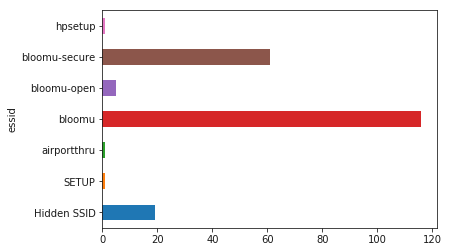

In [100]:
merged_data.groupby('essid')['clientmac'].count().plot(kind='barh')

# Great JOB